# Érzelemelemzés BERT-alapú modell segítségével

## Modell: SZTAKI-HLT/hubert-base-cc
Egy magyar BERT-alapú modell (pl. SZTAKI-HLT/hubert-base-cc vagy SZTAKI-HLT/hubert-base-cc) érzelmi osztályozásra való finomhangolása (fine-tuning) azt jelenti, hogy olyan adatokat adsz a modellnek, amelyből megtanulja, hogy egy szöveg pozitív, negatív vagy semleges hangulatú (vagy akár részletesebb érzelmi kategóriákba tartozik: félelem, szeretet, harag stb.).

In [304]:
#!pip install transformers datasets torch scikit-learn

In [305]:
#! pip install tf-keras

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch


2025-08-12 14:28:40.807719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 14:28:40.816487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755001720.827213   41044 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755001720.830718   41044 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755001720.839683   41044 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# korlátlan hosszúságban jelenik meg a szöveg teljes egészében a cellában, nem vágja le
pd.set_option('display.max_colwidth', None)
# Ezzel a beállítással a megjelenített sorok maximális száma 200 sorra nő
pd.set_option('display.max_rows', 200)

# Tapasztalat:
* Pozitív kategóriájú versek között sok negatív volt. Átnéztem őket

In [3]:
# ===== 1. CSV beolvasása =====
df_eredeti = pd.read_csv("vers_adatok.csv", encoding="utf-8")  # oszlopok: tipus, vers

# Versek szűrése

In [4]:
sorok = df_eredeti[df_eredeti['vers'].str.startswith('Van, hogy mellkasomra ül') ]
sorok

,tipus,szerzo,cim,vers,link
49,OFF,Kucman Annamária,Vendégeim,"Van, hogy mellkasomra ül a maró fájdalom. Nem hívom - csak jön, s én csendben fogadom. Kedves vendég Ő is: szívemet elé tárom, suttoghatja búját-baját - én hallgatom. Van, hogy mellkasomban dúdol az öröm. Kitár minden ablakot, táncol, könnyedén pörög. Kedves vendég Ő is: lelkemet átadom, kacaghatja dalát - én hallgatom. Kitombolták magukat, csendben elvonulnak. Még viszlátot sem mondanak.",https://poet.hu/vers/392518
103,OFF,Pete Margit,A felhőcske álma,"Van, hogy mellkasomra ül a maró fájdalom. Nem hívom - csak jön, s én csendben fogadom. Kedves vendég Ő is: szívemet elé tárom, suttoghatja búját-baját - én hallgatom. Van, hogy mellkasomban dúdol az öröm. Kitár minden ablakot, táncol, könnyedén pörög. Kedves vendég Ő is: lelkemet átadom, kacaghatja dalát - én hallgatom. Kitombolták magukat, csendben elvonulnak. Még viszlátot sem mondanak.",https://poet.hu/vers/388257


In [5]:
counts = df_eredeti['tipus'].value_counts()

print("OFF száma:", counts.get('OFF', 0))
print("poz száma:", counts.get('poz', 0))
print("neg száma:", counts.get('neg', 0))

OFF száma: 17
poz száma: 88
neg száma: 90


In [6]:
df_poz = df_eredeti[df_eredeti['tipus'] == 'poz'].copy()

In [7]:
df_poz.shape

(88, 5)

In [8]:
df_poz.head()

,tipus,szerzo,cim,vers,link
0,poz,Niiki,"Az leszek, minek te kívánsz","Az leszek, minek te kívánsz, Ha kell, feladom érted önmagam. Nem számít úgysem, hisz így látsz, A konok önérzet itt már hasztalan. Az leszek, minek te kívánsz, Ha csend kell, ígérem, hallgatok. Ha kéz kell, mi óv, s vigyáz. Tudod, örökkön veled ballagok. Az leszek, minek te kívánsz, Az igazam többé nem vágyom, Ahogy akarod, velem úgy bánsz, Lehetsz rideg tél, szép álom. Hát az leszek, minek te kívánsz, Hogy ki vagyok, én már nem tudom. De nem számít, mert így, így látsz, S én is, anélkül, hogy szemem lehunyom.",https://poet.hu/vers/394075
1,poz,Tóth Zoltán Attila,Tizenhárom év,"Drága Feleségemnek Tizenhárom éve lettél mindenem, Egy pillantásból született szerelem. Azóta együtt sírtunk, nevettünk, Tűzön-vízen át - kéz a kézben mentünk. Volt, hogy vihar tépte szívünk kertjét, De együtt gondoztuk tovább a reményt. A jónak örültünk, rosszban tanultunk, Nem csak házasok, de társak is voltunk. Tíz év után - szívem rég döntött, Életem Veled teljes és kötött. Akkor kértelek: legyél örökre társam, S már három éve Feleségem vagy álmomban s valóságban. És bár az idő ráncokat is sző, A szívemben ma is ugyanúgy nő Az érzés, mi akkor lángra kapott - Sosem hunyt ki, csak egyre nagyobb. Te vagy otthonom, csendem, zajom, Mindenem vagy, minden dalom. S ha újra kezdeném - csak Veled tenném, Mert Te vagy a kincsem, az örök szerelmem, a lényem.",https://poet.hu/vers/394067
2,poz,Földi László,A hegy,"Elindultam életem ösvényén, mely, úgy hiszem, Hozzád vezet. Nem látom, mi vár a legvégén, mert előttem van ez a hegy. A hegy, mit kikerülni nem tudok, mert a tetején kell leraknom terhemet. Lehet, hogy sokáig tart, mire feljutok, de meg kell tisztítanom a lelkemet. Ezt a hegyet én teremtettem meg, és legyőzni is nekem kell majd. Lehet, hogy a lábam néha megremeg, de felejteni akarok bút s bajt. Az utamon nem kísérhetsz el, mert Te is mászod a hegyedet. Talán felém indultál, s egyszer megfoghatom majd a kezedet. Mert mi vezeti az én lépteimet, az az irántad érzett szeretet. Ami bearanyozza az életemet, s így elbírok bármilyen terepet. Ha egyszer felérek a csúcsra, le fogom tenni minden terhemet. Elnézek majd a horizonton túlra, s keresni fogom páratlan fényedet. Nem tudhatom, hogy mikor megérkezem, ott leszel-e, s fogsz-e várni rám. Csak azt tudom, hogy én ott leszek, s várni foglak minden esős délután. Mert döntsön a sors bármit is, a szívem mindig a Tiéd lesz már. Ha nem lehetünk együtt, akkor is, Te szabadon szálló, gyönyörű madár.",https://poet.hu/vers/394044
3,poz,Dobos,Az Otthonom,"Álmaimban is üldözöl, Melegséged üdvözöl, Buta játékokat játszva Csalunk mosolyt egymás arcára. Erősen szorítottad a kezemet, S én is a tiédet, Nem tudom megállni, Hogy ne érintselek meg téged. Akárhányszor rád nézek Vagy rád gondolok, A boldog percek órákká nőnek, S rájövök, hogy te vagy az otthonom. Képtelen vagyok mással azt érezni, mint veled, Te egyedi voltál, vagy, s remélem, leszel is nekem.",https://poet.hu/vers/394022
4,poz,B. Beáta,Ölelés!,"Csak egy ölelés. Csak egy kis érték. Valami különleges, Valódi érzés. Gyógyító megérzés. Melengető, szívből jövő. Sebeket elfedő. Igazán lelket melengető! Ritka kincs. Lehet több ebből?",https://poet.hu/vers/393949


In [9]:
df_neg = df_eredeti[df_eredeti['tipus'] == 'neg'].copy()

# Az utólsó sort törlöm, hogy egyenő legyen a sorok száma a pozítív és a negatív dataframek-nél

In [10]:
df_neg = df_neg[:-2]

In [11]:
df_neg.shape

(88, 5)

In [12]:
df_neg.head()

,tipus,szerzo,cim,vers,link
105,neg,Sonorous,Az én Színházam,"Az én színházamban összedőlt már Az összes díszlet. A színpadon állok, közönség nélkül, Ahogy az összes lámpa elsötétül, Meghajolok, a maszkot leveszem, Hiszen mögötte sincs már egyebem, Mint egy színtelen, szürke maszat. Az én városomban szürke minden, S én arc és név nélkül sétálhatok, Hang nélkül a semmibe kiálthatok. Ismeritek őt? Hogyan? Kicsodát? Még sosem láttuk. Hát nem ismeritek A névtelenség fővárosát? Pedig az enyém, Én itt lakom. Ez az én városom, az én Színházam, az én élettelen létem. Itt minden szabály az én törvényem... Itt békében élhetek, amíg meg nem halok, Nem kísért a sok meg nem vívott harcom. Senki nem ismer, nem lát, Nem ismeri fel a lábnyomaim porát. És sírhatok, hangosan vagy csendesen, Sosem volt még ilyen emberi az embertelen.",https://poet.hu/vers/394080
106,neg,Békássy Balázs,Kaszál a sárkány,"Előzmény: Védtelen űrkutyák Örvény zavarja a levegőt, mi csapkod a szárnyaival? Keresgél a lény, de az orrában nincsen gőz. Pózna fogja a derekát, meglökték? Mintha megütötték volna. Elhajol a rúdja és fájlalja a fogait. Öltönybe bújt pap kap a levegőbe, de megy is valamire azzal a feszítővassal? Compó állkapcsát vonja kérdőre, az ellenség már a lengőajtón belül van. Árnyék fésüli a rémült s lélegzetét számláló anya haját, egy másik kismama odakint szellemként; babakocsit tol. A szemét eltakarják, Ő is bejönne inkább? Sötét a folyosó, de talán nem hörögnek a falak. A tűz odakint szórja vörös villámait, az ajtót zárjuk be! A torlasz álljon fel, mert ide nem lát be. A csapóajtó ereszkedjen fel, mindenhová nem követi az embert a hosszú kar kaparó vége. Óvatosan néz ki a két asszony az immár bealkonyult felszínre. A gyermekek csendben néznek, nézelődik a beton tükröződő tenyere.",https://poet.hu/vers/394076
107,neg,Fazekas Levente Áron,Négysoros,Csaholó levegővel törik be a tél. Az ég alá menekült a nap. Görnyed a piciny lámpafény. Magányos függöny libbent egy kadisát.,https://poet.hu/vers/394019
108,neg,Papp Ádám,Tudat alatt,"Különös, néma éjszaka ez. Csend zakatol itt, meddig belátsz A mélázó agynak zsebébe. Zakatol és soha meg nem áll Egy röpke nyugodt pillanatra. Csak rohan a végzetbe sután. Fogaskerekei csak lassan, Hangtalan kattogva őrölnek Porrá. Lelket s téged. Csak lágyan. Hisz folyton pusztít, tép, s megzavar, Megbújó gonosz tanácsadó. Csendes gépezet, mi felkavar. Eléd tár sok száz elzárt sebet, S kés módjára újakat fakaszt Fájdalomból, mi benned veszett. Díszítve ezt kínnal és vérrel, Nagyítva s lelkedbe tűt döfve. S feledsz valóságot, életet. S tudatlan állsz a szakadék szélén, Egyedül, belül zakatoló Démonaiddal. Már elvesztél.",https://poet.hu/vers/393845
109,neg,Szanyi Bence,Félelem,"Félelem? Elveszve, ténferegve hívogat az ég velem. Félelem? Élni, de csak óvatosan, íratlan szabályok börtönébe zárva. Valódi énünket csak soha, senki meg ne lássa. Ki voltam? Ki vagyok? Értelmetlen tűnődni. Nyelni egy nagyot, s el nem követett hibák miatt bűnhődni. Úgy tűnhet, az út végtelen, mégis feleszmélsz, és véget ér. Ne hagyd hát, hogy győzzön a félelem.",https://poet.hu/vers/393783


# Azok a versek, amelyek Pozítívak voltak, de kiszedtem a listából

In [13]:
df_off = df_eredeti[df_eredeti['tipus'] == 'OFF'].copy()

In [14]:
df_off.head(10)

tipus                  szerzo  \
36   OFF   Majszterics Vanessza.   
49   OFF        Kucman Annamária   
58   OFF                Morrancs   
61   OFF              Annnonimus   
67   OFF           Vadász Attila   
68   OFF          Békássy Balázs   
81   OFF              Tóth Tünde   
83   OFF            Sólyom Gábor   
86   OFF  Ibolya Lakatosné Bungó   
90   OFF   Majszterics Vanessza.   

                                             cim  \
36                            Mit egykor éreztem   
49                                     Vendégeim   
58                                Déli boldogság   
61                                 Nem én vagyok   
67                                Összemelegedek   
68                              Tükröződő szikla   
81  Az irodalom háztartási balesetei - Minieposz   
83                        Ki kivel van és miért?   
86                         Vizsga után (morzsák)   
90                              Most, amit érzek   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [15]:
df = pd.concat([df_poz, df_neg], ignore_index=True)
df.shape

(176, 5)

In [16]:
# Címkék számmá alakítása
label_map = {"poz": 0, "neg": 1}
df["label"] = df["tipus"].map(label_map)

In [17]:
# ===== 2. Train–test split =====
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [18]:
train_df.shape

(140, 6)

In [19]:
train_df.head()

,tipus,szerzo,cim,vers,link,label
53,poz,Király Dávid (Zsoltáros),Boldogság titka,"Boldogságom, boldogságom enyém, tiéd, családágon Vidám kedvvel elnáspángol anyám pedig krumplipártol Gyerekeim vígan sírnak odamennek, verset írnak Kegyelmemmel el nem bírnak Bizony, szép így ez az élet A világ egy befőtté lett Széttört üveg, éles bőr Vére édes lényekből adott emberlényegből",https://poet.hu/vers/392045,0
11,poz,Péteriné J. Erzsébet,Anna napon kinyíltak a rózsák,"Anna napon kinyíltak a rózsák, szépek; színes, bólogató jóság, köszöntik a fényes napvilágot, szívük adják, s illatos virágot. Ünneplőbe öltözött a kertünk, felkelt a nap, felvidult a kedvünk, köszöntünk most téged, drága Anna, legyen tiéd ez a szép hozsanna. Emlékezünk elmúlt, rég’ Annákra, emlék kísér halhatatlanságba, múló élet, örök, édes álom vár reánk is, a Jóisten áldjon. Anna napon kinyílnak a rózsák, bennük az ég küldi édes csókját, virágos lesz szívünk, lelkünk nyáron, madár dalol szép dalt rózsaágon.",https://poet.hu/vers/393752,0
39,poz,Piroschka Iréne Geng,Pipacs-szerelem,"Búzatábla ma a lelkem, hullámzik, ha neved hallom, piros pipacs vagy te benne, szerelmesen égsz a vágytól.",https://poet.hu/vers/393332,0
68,poz,Tengeri Szépia,Mikor ér valami véget?,"Mikor ér valami véget? Ha kétségbeesetten keresed, hogy miért csinálod az egészet? Vagy ha már kiégett a lélek? Vagy befejezheted hamarabb, mert ez a szabad akarat? És honnan tudod, hogy jól döntöttél, kitartsál vagy meneküljél? Meddig vagy küzdő, reményteljes, s mikortól naiv, önmagadra veszedelmes? De végre döntöttél, és a döntéssel szabad lettél. Már nem tervezel, nem küzdesz, nem felelsz meg. Még sírsz, de már mosolyogsz a könnyeiden át. Már nem akarsz szétesni, s a sejtjeidben érzed az összetartozást. Már nem lüktet az agyad, a szíved lassan piheg. Legnagyobb szövetségesed magad vagy, s tudod, a jövő benned pihen.",https://poet.hu/vers/391923,0
105,neg,Angyal Dorottya,Sírj,"Sírj, ha fáj a lelked, Add ki magadból, amit csak lehet. Sírj, hogy megkönnyebbüljön lelked, És ne szégyelld kimondani, Amit érzel. Lehet, hogy sírsz legbelül, Hogy bántottak - De idővel meglátod: Jobb vagy, mint az átlag. Ne sírj, ha az élet kemény veled, A sors azt akarja: ne add fel! Én is sírtam rengeteget - Hol örömömben, Hol a fájdalom gyötört. Sírni nem szégyen, Mindenkiből kitör az érzelem. Érzelem nélkül nem lehet sírni - Aki ezt mondja, az csak hazudik. A múltban, lehet, hogy sírtál rengeteget, És lehet, sokat fogsz sírni a jövőben is. De ha elérsz valamit az életben, Amiről mindig is álmodtál, Akkor azért fogsz sírni - Mert elérted a legnagyobb vágyad.",https://poet.hu/vers/390328,1


In [20]:
train_df_poz = train_df[train_df['tipus'] == 'poz'].copy()

In [21]:
train_df_poz.shape

(70, 6)

In [22]:
test_df.shape

(36, 6)

In [23]:
test_df.head()

,tipus,szerzo,cim,vers,link,label
63,poz,T. Jósa Miklós,Déli harangszó,"Déli harang, hintánk újra megáll; bozóttűzben megtisztult már az éhség; bemutatja ég felé áldozatát. Hittel ebédelni jó, semmi kétség. Pehelysúlyú szalmakalap alatt örökzöld a fennkölt gondolat, áldás. Jó ember - rímek belsejét faragd. Szereld be, mit egy szókép odapányváz. Ah, érzelmek korlátja, tüzes érv, szaladni készül, lángja holt, kialszik meggyújtás előtt; csalfán aranylik. Elvakultam, hízelgő ellenérv igazam áldozta le napnyugtával. S kenyeret majszolok zakuszkával.",https://poet.hu/vers/392511,0
96,neg,Yelchowt Elisabeth,Beléd égtem,"Szemerkélő esőben állunk kint kettesben. Esernyőnket nem nyitjuk, s a naplementét csodáljuk. Egymást nem is sajnáljuk, hagyva a szót, hadd szálljon. Nem kell tovább váratnod, ítéletét elhagytuk. Komolytalan arcodon, komolyságod láthatom. Ártatlanul pislogsz most, bár ajkad élve tépne húst. Kegyetlenség árad szét, de fájdalmasan jó e kép. Elfelejtett igaz lét, kegyelmes vagy, nem kérdés.",https://poet.hu/vers/393517,1
23,poz,Szabó László (szli),Drága Anikó!,"Csendes kis utcában rendes házikó, Itt szerelmünk a legfontosabb lakó. Nagyvilágban züllött, bűnös a dáridó, A mi udvarunkon énekel a fekete rigó. Élj 100 évig, csak azt kívánom neked, Amíg csak élek, legyen áldott a neved. Mai napon néked minden jót kívánok, Ahova csak nézel, ott nyíljanak virágok. Legyen forróság, vagy szakadjon a hó, Veled elbújni együtt mindig nagyon jó. Tudom, már hajam ritka, fehér és fakó, Úgy nézek már ki, mint egy öreg manó. De te megmaradtál fiatal és csillogó, Még mindig szép, mosolygó és izgató. Egy mosolygós démon, pajkos csábító. Nem engedlek el soha én, drága Anikó. Ha majd belepi emlékemet a fehér hó, Tőled hullámzik majd a szerelemfolyó. Ha megfeneklik majd ez a drága hajó, Akkor is szeretlek téged, drága Anikó!",https://poet.hu/vers/393409,0
82,poz,Voodoo,Szíveddel dobban,"Minden versed kotta, hullámzó dallam, amitől sötét egem lángra lobban, hallom szívdobbanásod, lüktet lassan, mintha itt tartanálak a karomban. Lejátszom újra és újra, hogy halljam, ott lebeg halkan mindegyik dalomban, játszom napfényben, esőben és fagyban, szívem szíveddel dobban mellkasomban. Távol vagy, de sohasem hagysz egyedül, a széllel üzensz, most is épp hegedül, veled alszik el, s veled ébred a fény. Zenémben, nem titok, ott él a remény, néha elkerül, de mindig visszatér... Leül melléd, rád mosolyog, s elrepül...",https://poet.hu/vers/389955,0
51,poz,Szajkó István,A Boldogság Titkai,"Volt egyszer egy érzés, lágy, mint reggeli fény, Nem harsány szó, nem vakító, csak csendes, tiszta remény. Nem mérhető pénzben, sem hírnév súlyában, De ott lakozik minden szív kis zugában. A boldogság néha egy csésze tea, Ha csendben kortyolod, s békéd megtalálja. Máskor egy mosoly, mit rég nem vártál, Egy pillantás, amitől lelkedbe nyár száll. Ott van az első harapásban, mikor otthon ízét érzed, Vagy egy régi dallamban, amit együtt énekeltél régen. Ott van a sétában, ha a szél arcodba kap, S a világ hirtelen megszűnik zűrzavarosnak. Boldogság az is, ha már nem félsz, Ha megérted, mi fontos, és mi, ami csak dísz. Ha nem rohanás az élet, hanem lépés, ami számít, Észreveszed a színeket, a halk neszeket, bármit. Lehet egy ölelés, egy baráti szó, Egy gondolat, mi elindít, mint hegy tetején a hó. A boldogság nem cél, mit el kell érni, Hanem út, amin érdemes végigmenni, s élni. S ha néha el is tűnik, mint álom hajnalban, Megtalálhatod újra egy gyermek kacajában. Mert mindig ott lesz, ha keresed szíveddel, A boldogság nem messze van - benned él csendesen.",https://poet.hu/vers/392282,0


In [24]:
test_df_poz = test_df[test_df['tipus'] == 'poz'].copy()

In [25]:
test_df_poz.shape

(18, 6)

In [26]:
# ===== 3. Tokenizer betöltése =====
tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")

In [27]:
# ===== 4. Tokenizáló függvény =====
def tokenize_function(examples):
    return tokenizer(
        examples["vers"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [28]:
# ===== 5. Dataset-ek létrehozása =====
train_dataset = Dataset.from_pandas(train_df[["vers", "label"]])
test_dataset = Dataset.from_pandas(test_df[["vers", "label"]])


train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [29]:
train_dataset

Dataset({
    features: ['vers', 'label', '__index_level_0__'],
    num_rows: 140
})

In [30]:
test_dataset

Dataset({
    features: ['vers', 'label', '__index_level_0__'],
    num_rows: 36
})

# Dropout működése
* A tanítás során véletlenszerűen "kikapcsol" (azaz nulláz) egy előre meghatározott arányban (pl. 10%, 30%) neuronokat az idegháló egy adott rétegében.

* Ezáltal a hálózat nem tud túlzottan "rászokni" bizonyos jellemzőkre, mert mindig más részek működnek aktívan.

* Ez segít, hogy a modell általánosabb megoldást tanuljon, ne csak a tanító adat mintáit.

In [31]:

# ===== 6. Modell betöltése =====
'''
model = BertForSequenceClassification.from_pretrained(
    "SZTAKI-HLT/hubert-base-cc",
    num_labels=2  # pozitív / negatív
)
'''
# Dropout növelése
model = BertForSequenceClassification.from_pretrained(
    "SZTAKI-HLT/hubert-base-cc",
    num_labels=2,  # pozitív / negatív
    hidden_dropout_prob=0.3,  # alap 0.1 → növelve
    attention_probs_dropout_prob=0.3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# ===== 7. Tanítási beállítások =====
training_args = TrainingArguments(
    output_dir="./bert_vers_hangulat",
    #evaluation_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    #num_train_epochs=10, # túltanul
    num_train_epochs=6, # itt még csökkent a validation_loss
    per_device_train_batch_size=4,
    #learning_rate=1e-5,
    #Ha túl nagy a learning rate, a modell paraméterei "túl nagyot ugranak", és nem tud stabilan konvergálni.
    learning_rate=5e-6,  # fele akkora
    logging_dir="./logs",
    logging_steps=10
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# ===== 12. Pontosság kiértékelő függvény =====
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [34]:
# ===== 13. Trainer újradefiniálása metric-kel =====
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_41044/2982156493.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## A wandb.ai (Weights & Biases) egy AI fejlesztői platform
A wandb.ai egy átfogó, sokoldalú eszközkészlet, amely segít a gépi tanulási modellek fejlesztésének, finomhangolásának, megosztásának és monitorozásának egyszerűsítésében és skálázásában.

API kulcs innen regisztráció után:
https://wandb.ai/authorize?ref=models

# Train tapasztalatok

* num_train_epochs=6, Pontosság: 83.3%
* num_train_epochs=7, Pontosság: 80%
* num_train_epochs=5, Pontosság: 76.8%

In [35]:
# ===== 9. Modell tanítása =====
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.639100,0.630675,0.611111
2,0.649400,0.613415,0.722222
3,0.584400,0.551198,0.805556
4,0.534000,0.467326,0.861111
5,0.415400,0.458046,0.833333
6,0.454100,0.446032,0.833333


TrainOutput(global_step=210, training_loss=0.5628577186947777, metrics={'train_runtime': 48.8321, 'train_samples_per_second': 17.202, 'train_steps_per_second': 4.3, 'total_flos': 55253321625600.0, 'train_loss': 0.5628577186947777, 'epoch': 6.0})

In [36]:
kimenet_versek =[]

In [37]:
# ===== 10. Függvény új versek értékelésére =====
def predikcio(uj_df):

    global model, tokenizer, label_map 

    uj_versek = uj_df["vers"].tolist()

    label_map = {"poz": 0, "neg": 1}
    uj_df["tipus"] = uj_df["tipus"].map(label_map)
    true_labels = uj_df["tipus"].values  # string címkék


    model.eval()

    #A tokenizer(...) után a bemeneti tensort is ugyanarra az eszközre kell rakni, ahol a model van.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    inputs = tokenizer(uj_versek, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)  # <-- fontos: ide is to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()  # CPU-ra vissza, ha numpy kell

    # Pontosság számítása
    acc = accuracy_score(true_labels, predictions)
    print(f"Pontosság az új verseken: {acc*100:.2f}%")

    inverse_label_map = {0: "poz (pozitív)", 1: "neg (negatív)"}

    for szerzo, cim,  vers, link, pred, valodi in zip(uj_df["szerzo"] , uj_df["cim"], uj_df["vers"], uj_df["link"], predictions, true_labels):
        print(f"Vers: {vers[:40]}... Predikció: {inverse_label_map[pred]} | Valódi: {inverse_label_map[valodi]}")
        adat = {
            "szerzo": szerzo,
            "cim": cim,
            "vers": vers,
            "link" : link,
            "valodi": inverse_label_map[valodi],
            "predikcio": inverse_label_map[pred]
        }
        kimenet_versek.append(adat)


In [38]:
# ===== Új CSV beolvasása =====

uj_versek = pd.read_csv("ellenorzo_vers_adatok.csv", encoding="utf-8")  # tipus, vers oszlopok



# Biztonsági ellenőrzés, hogy vannak-e azonos versek

In [39]:


kozos_cimek_szerzok = pd.merge(df, uj_versek, on=['cim', 'szerzo'])
kozos_cimek_szerzok

,tipus_x,szerzo,cim,vers_x,link_x,label,tipus_y,vers_y,link_y


In [40]:
predikcio(uj_versek)

Pontosság az új verseken: 76.47%
Vers: Tanulj meg igazán szeretni, szomorú könn... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Nem mondtuk ki, mégis tudtuk, szem a sze... Predikció: neg (negatív) | Valódi: poz (pozitív)
Vers: Van egy szó, a széthúzás, vagy én, vagy ... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Apró cipőcskéd cipőfűzői Úgy fonták át l... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Az ember azt hiszi, a szeretet olyan, ak... Predikció: neg (negatív) | Valódi: poz (pozitív)
Vers: Egy kertben ültem halk fák alatt, Lágy s... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Alap, mit mindenki ért, az élet, az otth... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Az igaz szeretet sosem hangos... S az se... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Öleld át a sok-sok megfáradtat, Hisz a s... Predikció: poz (pozitív) | Valódi: poz (pozitív)
Vers: Előzmény: Életem - 4. részlet Elballagtu... Predikció: neg (negatív) |

In [41]:
# Lista → DataFrame
kimenet_df = pd.DataFrame(kimenet_versek)

In [42]:
kimenet_df.shape


(221, 6)

In [43]:
egyezesek_szama = (kimenet_df["valodi"] == kimenet_df["predikcio"]).sum()
print("Egyezések száma:", egyezesek_szama)

Egyezések száma: 169


In [44]:
egyezesek_szama = (kimenet_df["valodi"] == kimenet_df["predikcio"]).sum()
pontossag = egyezesek_szama / kimenet_df.shape[0] * 100  # százalékos érték
print(f"Pontosság: {pontossag:.2f}%")

Pontosság: 76.47%


In [45]:

# Mentés CSV-be (UTF-8 kódolással)
kimenet_df.to_csv("kimenet_versek.csv", index=False, encoding="utf-8")

In [49]:
kimenet_df.to_excel("kimenet_versek.xlsx", index=False)

In [47]:
# ===== 15. Validációs eredmények kiírása =====
eval_result = trainer.evaluate()
print(f"Pontosság: {eval_result['eval_accuracy']*100:.2f}%")

Pontosság: 83.33%


Ha a validation_loss egy pont után emelkedik, az overfitting kezdete ott van → ott érdemes leállítani az epoch-okat.

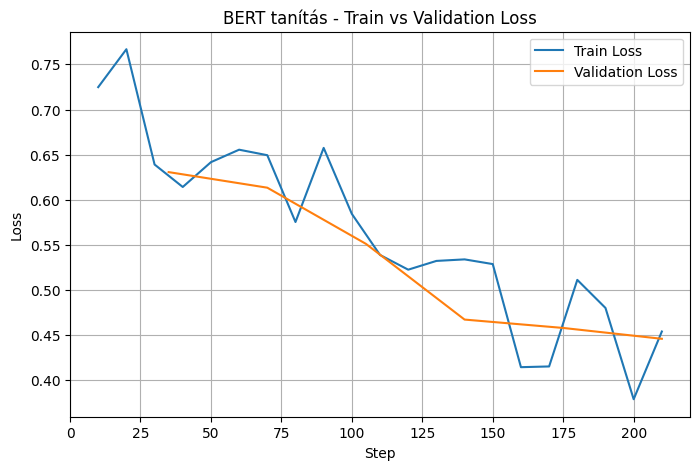

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# TensorBoard log mappa (training_args.logging_dir)
log_dir = "./logs"

# TensorBoard adatok betöltése
# (A scalar fájlokból kiszedi az "epoch", "train_loss", "eval_loss" értékeket)
def load_tb_logs(log_dir):
    from tensorboard.backend.event_processing import event_accumulator
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    def extract_scalar(tag):
        if tag in ea.Tags()["scalars"]:
            return [(s.step, s.value) for s in ea.Scalars(tag)]
        return []

    train_loss = extract_scalar("train/loss")
    eval_loss = extract_scalar("eval/loss")

    return train_loss, eval_loss

train_loss, eval_loss = load_tb_logs(log_dir)

# Adatok DataFrame-be
df_train = pd.DataFrame(train_loss, columns=["step", "train_loss"])
df_eval = pd.DataFrame(eval_loss, columns=["step", "eval_loss"])

# Rajzolás
plt.figure(figsize=(8,5))
plt.plot(df_train["step"], df_train["train_loss"], label="Train Loss")
plt.plot(df_eval["step"], df_eval["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("BERT tanítás - Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
